データの加工を行い、2と同様にLightGBMで分析を行った

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

import collections

import lightgbm as lgb

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

Duplicate key in file WindowsPath('C:/Users/GuestUser/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family:  IPAexGothic')


In [2]:
pd.set_option('display.max_rows', None)

データを変数に入れる

In [3]:
train = pd.read_table('train.tsv')
test = pd.read_csv('test.tsv',sep='\t')
sample = pd.read_csv('sample_submit.csv',header=None)

データを見る・データを整える　※native-countryについて、trainかtest片方にしかないものは？に変換してしまう。

In [4]:
train = train.replace({"Y":{"<=50K" : 0, ">50K" : 1}})

In [5]:
trainX = train.iloc[:,0:15]
y = train["Y"]
testX = test.copy()

In [6]:
train = train.drop(columns=["id","education"])
trainX = trainX.drop(columns=["id","education"])
testX = testX.drop(columns=["id","education"])

In [7]:
indexNum = testX[~testX["native-country"].isin(trainX["native-country"].unique())].index
for i in indexNum:
    testX.iat[i,12] = "?"

In [13]:
workclass = pd.crosstab(trainX["workclass"],y,margins=True)
workclass["ratio"] = workclass[1]/workclass["All"]
workclass["odds"] = workclass[1]/workclass[0]
workclass.sort_values(by="ratio")

Y,0,1,All,ratio,odds
workclass,,,,,
Never-worked,4,0,4,0.000000,0.000000
Without-pay,6,0,6,0.000000,0.000000
?,858,92,950,0.096842,0.107226
Private,8756,2525,11281,0.223828,0.288374
All,12288,3992,16280,0.245209,0.324870
Self-emp-not-inc,923,358,1281,0.279469,0.387866
State-gov,470,183,653,0.280245,0.389362
Local-gov,714,319,1033,0.308809,0.446779
Federal-gov,318,194,512,0.378906,0.610063


In [14]:
trainX = trainX.replace({'workclass':['?', 'Never-worked', 'Without-pay']}, 0)
trainX = trainX.replace({'workclass':['Private']}, 1)
trainX = trainX.replace({'workclass':['Self-emp-not-inc','State-gov','Local-gov']}, 2)
trainX = trainX.replace({'workclass':['Federal-gov']}, 3)
trainX = trainX.replace({'workclass':['Self-emp-inc']}, 4)

In [15]:
testX = testX.replace({'workclass':['?', 'Never-worked', 'Without-pay']}, 0)
testX = testX.replace({'workclass':['Private']}, 1)
testX = testX.replace({'workclass':['Self-emp-not-inc','State-gov','Local-gov']}, 2)
testX = testX.replace({'workclass':['Federal-gov']}, 3)
testX = testX.replace({'workclass':['Self-emp-inc']}, 4)

In [16]:
maritalstatus = pd.crosstab(trainX["marital-status"],y,margins=True)
maritalstatus["ratio"] = maritalstatus[1]/maritalstatus["All"]
maritalstatus["odds"] = maritalstatus[1]/maritalstatus[0]
maritalstatus.sort_values(by="ratio")

Y,0,1,All,ratio,odds
marital-status,,,,,
Never-married,5083,263,5346,0.049196,0.051741
Separated,468,34,502,0.067729,0.072650
Married-spouse-absent,210,16,226,0.070796,0.076190
Widowed,460,37,497,0.074447,0.080435
Divorced,1993,247,2240,0.110268,0.123934
All,12288,3992,16280,0.245209,0.324870
Married-AF-spouse,9,7,16,0.437500,0.777778
Married-civ-spouse,4065,3388,7453,0.454582,0.833456


In [17]:
trainX = trainX.replace({'marital-status':['Never-married', 'Separated', 'Married-spouse-absent','Widowed','Divorced']}, 0)
trainX = trainX.replace({'marital-status':['Married-AF-spouse', 'Married-civ-spouse']}, 1)

In [18]:
testX = testX.replace({'marital-status':['Never-married', 'Separated', 'Married-spouse-absent','Widowed','Divorced']}, 0)
testX = testX.replace({'marital-status':['Married-AF-spouse', 'Married-civ-spouse']}, 1)

In [19]:
occupation = pd.crosstab(trainX["occupation"],y,margins=True)
occupation["ratio"] = occupation[1]/occupation["All"]
occupation["odds"] = occupation[1]/occupation[0]
occupation.sort_values(by="ratio")

Y,0,1,All,ratio,odds
occupation,,,,,
Priv-house-serv,75,0,75,0.000000,0.000000
Other-service,1568,66,1634,0.040392,0.042092
Handlers-cleaners,636,37,673,0.054978,0.058176
?,862,92,954,0.096436,0.106729
Machine-op-inspct,848,117,965,0.121244,0.137972
Farming-fishing,440,64,504,0.126984,0.145455
Adm-clerical,1667,287,1954,0.146878,0.172166
Transport-moving,593,166,759,0.218709,0.279933
Craft-repair,1563,488,2051,0.237933,0.312220


In [20]:
relationship = pd.crosstab(trainX["relationship"],y,margins=True)
relationship["ratio"] = relationship[1]/relationship["All"]
relationship["odds"] = relationship[1]/relationship[0]
relationship.sort_values(by="ratio")

Y,0,1,All,ratio,odds
relationship,,,,,
Own-child,2522,39,2561,0.015228,0.015464
Other-relative,465,15,480,0.031250,0.032258
Unmarried,1587,111,1698,0.065371,0.069943
Not-in-family,3729,452,4181,0.108108,0.121212
All,12288,3992,16280,0.245209,0.324870
Husband,3565,2984,6549,0.455642,0.837027
Wife,420,391,811,0.482121,0.930952


In [21]:
trainX = trainX.replace({'relationship':['Own-child', 'Other-relative', 'Unmarried','Not-in-family']}, 0)
trainX = trainX.replace({'relationship':['Husband', 'Wife']}, 1)

In [22]:
testX = testX.replace({'relationship':['Own-child', 'Other-relative', 'Unmarried','Not-in-family']}, 0)
testX = testX.replace({'relationship':['Husband', 'Wife']}, 1)

In [23]:
race = pd.crosstab(trainX["race"],y,margins=True)
race["ratio"] = race[1]/race["All"]
race["odds"] = race[1]/race[0]
race.sort_values(by="ratio")

Y,0,1,All,ratio,odds
race,,,,,
Other,135,10,145,0.068966,0.074074
Black,1385,199,1584,0.125631,0.143682
Amer-Indian-Eskimo,123,18,141,0.127660,0.146341
All,12288,3992,16280,0.245209,0.324870
White,10270,3611,13881,0.260140,0.351607
Asian-Pac-Islander,375,154,529,0.291115,0.410667


In [24]:
trainX = trainX.replace({'race':['Other']}, 0)
trainX = trainX.replace({'race':['Black','Amer-Indian-Eskimo']}, 1)
trainX = trainX.replace({'race':['White','Asian-Pac-Islander']}, 2)

In [25]:
testX = testX.replace({'race':['Other']}, 0)
testX = testX.replace({'race':['Black','Amer-Indian-Eskimo']}, 1)
testX = testX.replace({'race':['White','Asian-Pac-Islander']}, 2)

In [26]:
sex = pd.crosstab(trainX["sex"],y,margins=True)
sex["ratio"] = sex[1]/sex["All"]
sex["odds"] = sex[1]/sex[0]
sex.sort_values(by="ratio")

Y,0,1,All,ratio,odds
sex,,,,,
Female,4827,617,5444,0.113336,0.127823
All,12288,3992,16280,0.245209,0.324870
Male,7461,3375,10836,0.311462,0.452352


In [27]:
trainX = trainX.replace({'sex':['Female']}, 0)
trainX = trainX.replace({'sex':['Male']}, 1)

In [28]:
testX = testX.replace({'sex':['Female']}, 0)
testX = testX.replace({'sex':['Male']}, 1)

In [29]:
nativeCountry = pd.crosstab(trainX["native-country"],y,margins=True)
nativeCountry["ratio"] = nativeCountry[1]/nativeCountry["All"]
nativeCountry["odds"] = nativeCountry[1]/nativeCountry[0]
nativeCountry.sort_values(by="ratio")

Y,0,1,All,ratio,odds
native-country,,,,,
Nicaragua,23,0,23,0.000000,0.000000
Outlying-US(Guam-USVI-etc),8,0,8,0.000000,0.000000
Honduras,5,0,5,0.000000,0.000000
Columbia,34,1,35,0.028571,0.029412
Guatemala,24,1,25,0.040000,0.041667
Mexico,317,15,332,0.045181,0.047319
Peru,17,1,18,0.055556,0.058824
Dominican-Republic,32,2,34,0.058824,0.062500
Portugal,15,1,16,0.062500,0.066667


In [30]:
pd.reset_option('display.max_rows')

LightGBMでモデルを作成

In [31]:
trainX = pd.get_dummies(trainX)
testX = pd.get_dummies(testX)

In [32]:
model = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trainX, y, test_size=0.3)

In [34]:
eval_set = [(X_test, y_test)]
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())
model.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)

[1]	valid_0's binary_logloss: 0.515686
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.485921
[3]	valid_0's binary_logloss: 0.462125
[4]	valid_0's binary_logloss: 0.441459
[5]	valid_0's binary_logloss: 0.424805
[6]	valid_0's binary_logloss: 0.410714
[7]	valid_0's binary_logloss: 0.398064
[8]	valid_0's binary_logloss: 0.387853
[9]	valid_0's binary_logloss: 0.37886
[10]	valid_0's binary_logloss: 0.3707
[11]	valid_0's binary_logloss: 0.363965
[12]	valid_0's binary_logloss: 0.35786
[13]	valid_0's binary_logloss: 0.352499
[14]	valid_0's binary_logloss: 0.347391
[15]	valid_0's binary_logloss: 0.343591
[16]	valid_0's binary_logloss: 0.339889
[17]	valid_0's binary_logloss: 0.336461
[18]	valid_0's binary_logloss: 0.333523
[19]	valid_0's binary_logloss: 0.329738
[20]	valid_0's binary_logloss: 0.327494
[21]	valid_0's binary_logloss: 0.324829
[22]	valid_0's binary_logloss: 0.322683
[23]	valid_0's binary_logloss: 0.320955
[24]	valid_0's binary_logloss: 0

LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

In [35]:
trainXpred = model.predict_proba(trainX)
trainXpred = trainXpred[:,1]
trainXl = len(trainXpred)
trainXpred = trainXpred.astype(object)
trainXpred

array([0.01921858541536259, 0.40619202514347674, 0.3067352093422916, ...,
       0.035645474516261794, 0.0010373106409842666, 0.19164859867634615],
      dtype=object)

In [36]:
ansRateList = pd.DataFrame()
for j in range(25):
    c = trainXpred.copy()
    n = (38+j)/100
    for i in range(trainXl):
        if c[i] <= n:
            c[i] = 0
        else:
            c[i] = 1
    ansRateBase = np.equal(c,y)
    ansRate = collections.Counter(ansRateBase)[True]/len(ansRateBase)
    ansRateData = pd.DataFrame([[n,ansRate]])
    ansRateList = pd.concat([ansRateList,ansRateData],ignore_index=True)
ansRateList

,0,1
0,0.38,0.868919
1,0.39,0.871253
2,0.40,0.872912
3,0.41,0.874816
4,0.42,0.875000
5,0.43,0.875553
6,0.44,0.875676
7,0.45,0.876106
8,0.46,0.876843
9,0.47,0.877457


([<matplotlib.axis.XTick at 0x1afe063e820>,
 [Text(0, 0, '0.38'),
  Text(1, 0, '0.39'),
  Text(2, 0, '0.4'),
  Text(3, 0, '0.41'),
  Text(4, 0, '0.42'),
  Text(5, 0, '0.43'),
  Text(6, 0, '0.44'),
  Text(7, 0, '0.45'),
  Text(8, 0, '0.46'),
  Text(9, 0, '0.47'),
  Text(10, 0, '0.48'),
  Text(11, 0, '0.49'),
  Text(12, 0, '0.5'),
  Text(13, 0, '0.51'),
  Text(14, 0, '0.52'),
  Text(15, 0, '0.53'),
  Text(16, 0, '0.54'),
  Text(17, 0, '0.55'),
  Text(18, 0, '0.56'),
  Text(19, 0, '0.57'),
  Text(20, 0, '0.58'),
  Text(21, 0, '0.59'),
  Text(22, 0, '0.6'),
  Text(23, 0, '0.61'),
  Text(24, 0, '0.62')])

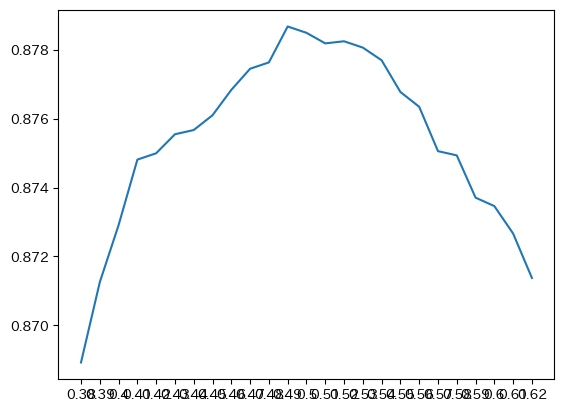

In [37]:
plt.plot(ansRateList[1])
plt.xticks(range(25),ansRateList[0])

予測に代入して結果を出力する

In [48]:
from sklearn import metrics
pred = model.predict_proba(testX)

In [49]:
pred = pred[:,1]
l = len(pred)

In [50]:
pred = pred.astype(object)
for i in range(l):
    if pred[i] <= 0.50:
        pred[i] = "<=50K"
    else:
        pred[i] = ">50K"

In [51]:
sample[1] = pred

In [52]:
sample.to_csv("submit3_2.csv",index=None,header=None)